In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from dataset import Dataset
import tensorflow as tf

os.environ['KERAS_BACKEND'] = 'tensorflow'

In [2]:
import keras

print("Keras version:", keras.__version__)

Keras version: 3.10.0


In [3]:
from typing import Literal


def get_running_environment() -> Literal['local', 'colab', 'kaggle', 'marimo', 'jupyter']:
    """
    Returns the current running environment.
    """
    if 'COLAB_GPU' in os.environ:
        return 'colab'
    elif 'KAGGLE_URL_BASE' in os.environ:
        return 'kaggle'
    elif 'MARIMO' in os.environ:
        return 'marimo'
    elif 'JUPYTERHUB_USER' in os.environ:
        return 'jupyter'
    else:
        return 'local'
current_env = get_running_environment()

def get_data_path(running_env: str) -> str:
    """
    Returns the path to the data directory based on the running environment.
    """
    if running_env == 'colab':
        return '/content/data'
    elif running_env == 'kaggle':
        return '/kaggle/input/histopathologic-cancer-detection'
    elif running_env == 'marimo':
        return '/data'
    else:
        return './data'

data_dir = get_data_path(current_env)
print(f"Data path: {data_dir} (for {current_env} environment)")

Data path: ./data (for local environment)


In [4]:
dataset = Dataset(data_dir)
dataset

Showing random image with ID: 9c52d1f0332d2b1480f83e637509e58521d4dc64
Showing random image from: ./data/train/9c52d1f0332d2b1480f83e637509e58521d4dc64.tif


Dataset(folder_path=./data, train_labels_file=./data/train_labels.csv, train_images_dir=./data/train, test_images_dir=./data/test, sample_submission_file=./data/sample_submission.csv)

## Exploratory Data Analysis (EDA)

In [5]:
train_df = dataset.train_df
print("Train DataFrame shape:", train_df.shape)
print("Train DataFrame columns:", train_df.columns.tolist())
train_df.head()

Train DataFrame shape: (220025, 2)
Train DataFrame columns: ['id', 'label']


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Showing random image with ID: 4b5d4c77407d8d193933358094b39c70c6350209
Showing random image from: ./data/train/4b5d4c77407d8d193933358094b39c70c6350209.tif
Image shape: (96, 96, 3)


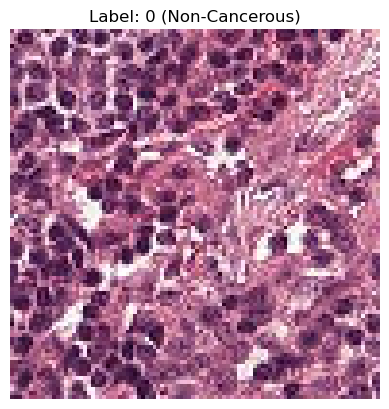

<Figure size 800x600 with 0 Axes>

In [6]:
image_info = dataset.get_random_train_image()

label = train_df[train_df['id'] == image_info.image_id]['label'].values[0]
img = plt.imread(image_info.image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Label: {label} ({'Cancerous' if label == 1 else 'Non-Cancerous'})")

print(f"Image shape: {image_info.shape}")
plt.figure(figsize=(8, 6))
plt.show()

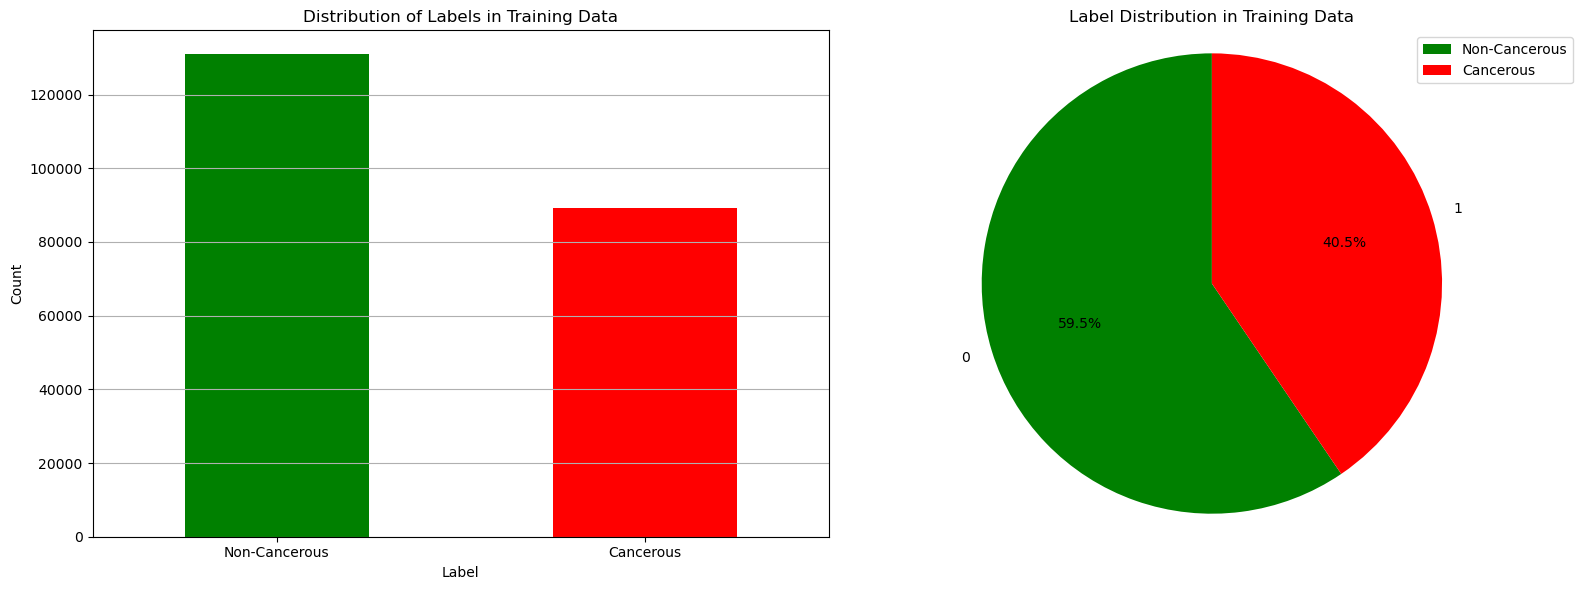

In [7]:
# Visualizing the distribution of labels in the training dataset
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of label counts on the left
train_df['label'].value_counts().plot(
    kind='bar',
    ax=axes[0],
    color=['green', 'red']
)
axes[0].set_title('Distribution of Labels in Training Data')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Non-Cancerous', 'Cancerous'], rotation=0)
axes[0].grid(axis='y')

# Pie chart of percentage distribution on the right
train_df['label'].value_counts().plot(
    kind='pie',
    ax=axes[1],
    autopct='%1.1f%%',
    startangle=90,
    colors=['green', 'red']
)
axes[1].set_title('Label Distribution in Training Data')
axes[1].legend(['Non-Cancerous', 'Cancerous'], loc='upper right')
axes[1].set_ylabel('')
axes[1].axis('equal')

plt.tight_layout()
plt.show()

In [8]:
# print(f"Found {len(dataset.get_skip_image_ids())} images with invalid format in the training directory.")

In [9]:
ds = dataset.load_tf_dataset()

2025-07-21 06:22:48.126484: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-07-21 06:22:48.126510: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-21 06:22:48.126520: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1753071768.127079 12914889 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1753071768.127094 12914889 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Shuffle and take 500 random samples
buffer_size = 10000
random_ds = ds.shuffle(buffer_size=buffer_size, seed=42).take(50000)

for image, label, img_id in random_ds:
    image_np = image.numpy()  # Convert tensor to NumPy array
    img_id_str = img_id.numpy().decode('utf-8')  # Convert tf.string to Python string
    
    # Look up original label from train_df
    original_label = dataset.train_df[dataset.train_df['id'] == img_id_str]['label'].values[0]
    
    # Print details with cross-check
    # print(f"Image ID: {img_id_str}")
    # print(f"Image shape: {image_np.shape}, dtype: {image_np.dtype}")
    # print(f"Dataset Label: {label.numpy()}, dtype: {label.dtype} (Cancer: {'Yes' if label.numpy() == 1 else 'No'})")
    # print(f"Original Label from train_df: {original_label} (Matches: {label.numpy() == original_label})")
    # print(f"Pixel range: min={np.min(image_np):.2f}, max={np.max(image_np):.2f}")
    # print(f"original label: {original_label} (TF Dataset label: {label.numpy()})")
    assert original_label == label.numpy(), "Mismatch between dataset label and original label from train_df"
    # print("-" * 50)
    # # Visualize
    # plt.figure(figsize=(4, 4))
    # plt.imshow(image_np)
    # plt.title(f"ID: {img_id_str} | Dataset Label: {label.numpy()} | Original Label: {original_label}")
    # plt.axis('off')
    # plt.show()
print(f"All labels match with the original train_df labels.")

All labels match with the original train_df labels.
